In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore")

# Step 1 : Loading Data

In [2]:
df=pd.read_csv('SeaPlaneTravel.csv')
df.head()

,Month,#Passengers
0,2003-01,112
1,2003-02,118
2,2003-03,132
3,2003-04,129
4,2003-05,121


In [3]:
df.Month=pd.to_datetime(df.Month)
df.set_index('Month',inplace=True)
df_org=df.copy() # Taking a copy just for backup
df.head()

,#Passengers
Month,
2003-01-01,112
2003-02-01,118
2003-03-01,132
2003-04-01,129
2003-05-01,121


# Step 2 : Check Stationarity of the time series

<AxesSubplot:xlabel='Month'>

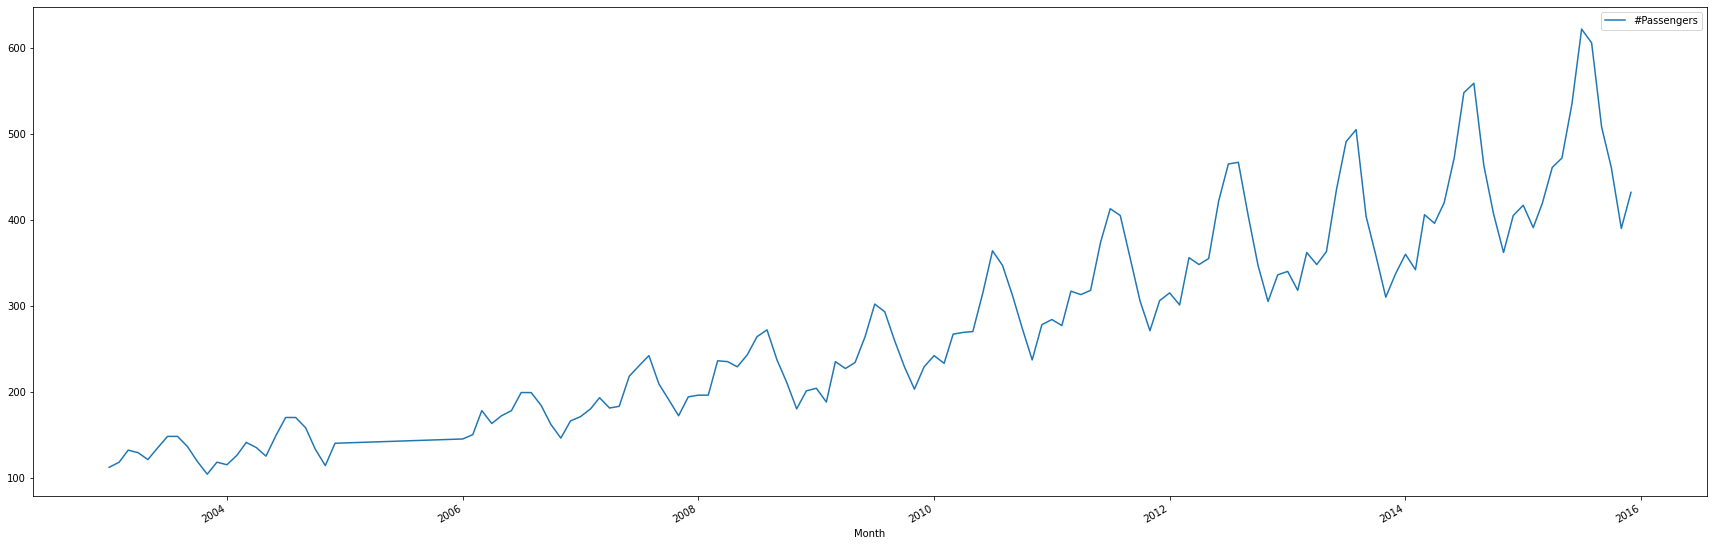

In [4]:
# Plotting on date axis to check Stationarity of the Time Series
df.plot(figsize=(30,10))

It is clearly evident that there is an overall increasing trend in the data along with some seasonal variations. However, it might not always be possible to make such visual inferences. So, more formally, we can check stationarity using rolling stats and Dick fuller test

In [5]:
#Defining a dataframe to hold all ADF stats
adf=pd.DataFrame(index=['ADF Statistic','p-value','#Lags Used','#Observations Used','Critical Value 1%','Critical Value 5%','Critical Value 10%'])
#Function is to be defined as we may need to run the test multiple times with different input
def test_stationarity(timeseries):
#Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    rolvar = timeseries.rolling(12).var()
#Plotting the rolling statistics
    plt.figure(figsize=(30,10))
    plt.plot(timeseries,c='b',label='Original')
    plt.plot(rolmean,c='r',label='Rolling Mean')
    plt.plot(rolstd,c='g',label='Rolling STD')
    #plt.plot(rolvar,c='y',label='Rolling Var')
    plt.legend()
    plt.show()
#Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    adf = adfuller(timeseries,)
    print('ADF Statistic      : ',adf[0])
    print('p-value            : ',adf[1])
    print('#Lags Used         : ',adf[2])
    print('#Observations Used : ',adf[3])
    for key,value in adf[4].items():
        print('Critical Value {}  : {}'.format(key,value))
    return [adf[0],adf[1],adf[2],adf[3],adf[4]['1%'],adf[4]['5%'],adf[4]['10%']]

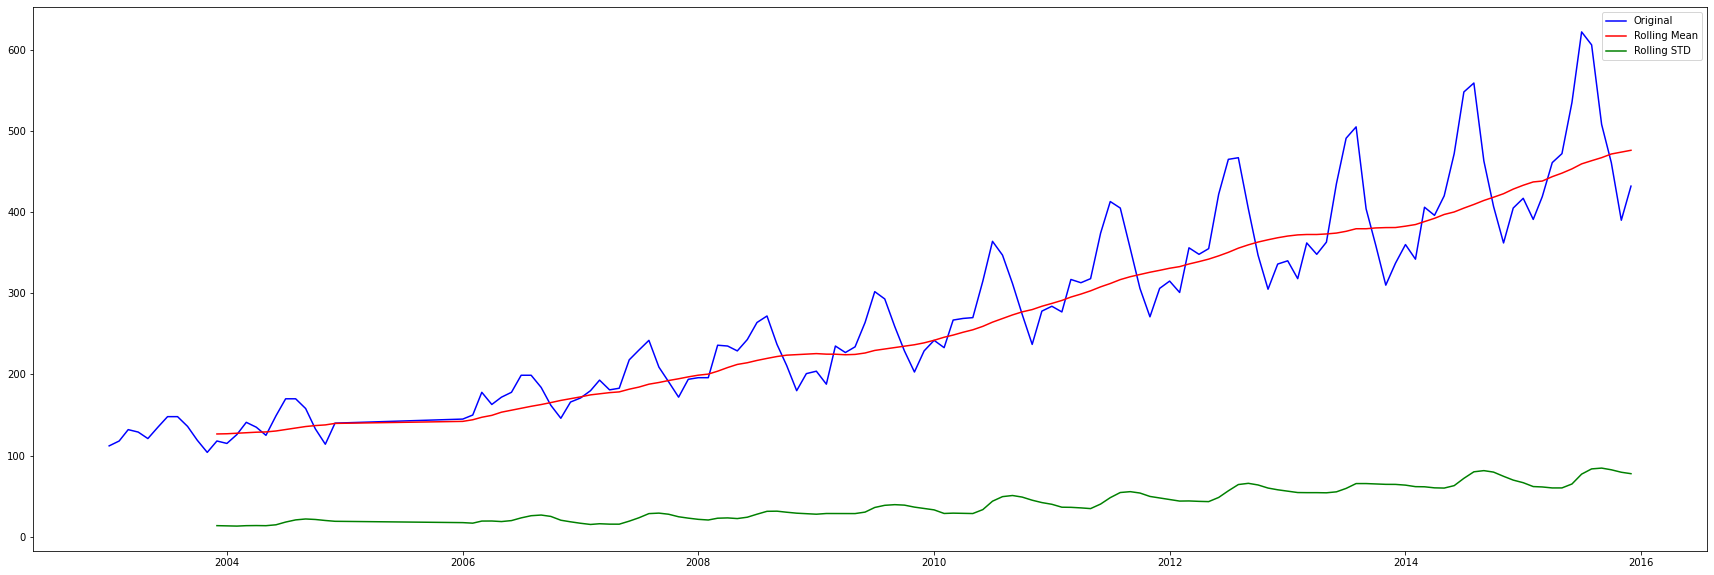

Results of Dickey-Fuller Test:
ADF Statistic      :  0.8153688792060423
p-value            :  0.9918802434376409
#Lags Used         :  13
#Observations Used :  130
Critical Value 1%  : -3.4816817173418295
Critical Value 5%  : -2.8840418343195267
Critical Value 10%  : -2.578770059171598


In [6]:
#testing stationarity of original time series
adf['Original']=test_stationarity(df)

p-value > 0.05 means Times series is non-stationary
and the statistic is larger than the critical values

# Step 3 : Transform time series to have stationarity

In [7]:
#Trying to log transform the series to make it stationary
df_log=np.log(df)
df_log.head()

,#Passengers
Month,
2003-01-01,4.718499
2003-02-01,4.770685
2003-03-01,4.882802
2003-04-01,4.859812
2003-05-01,4.795791


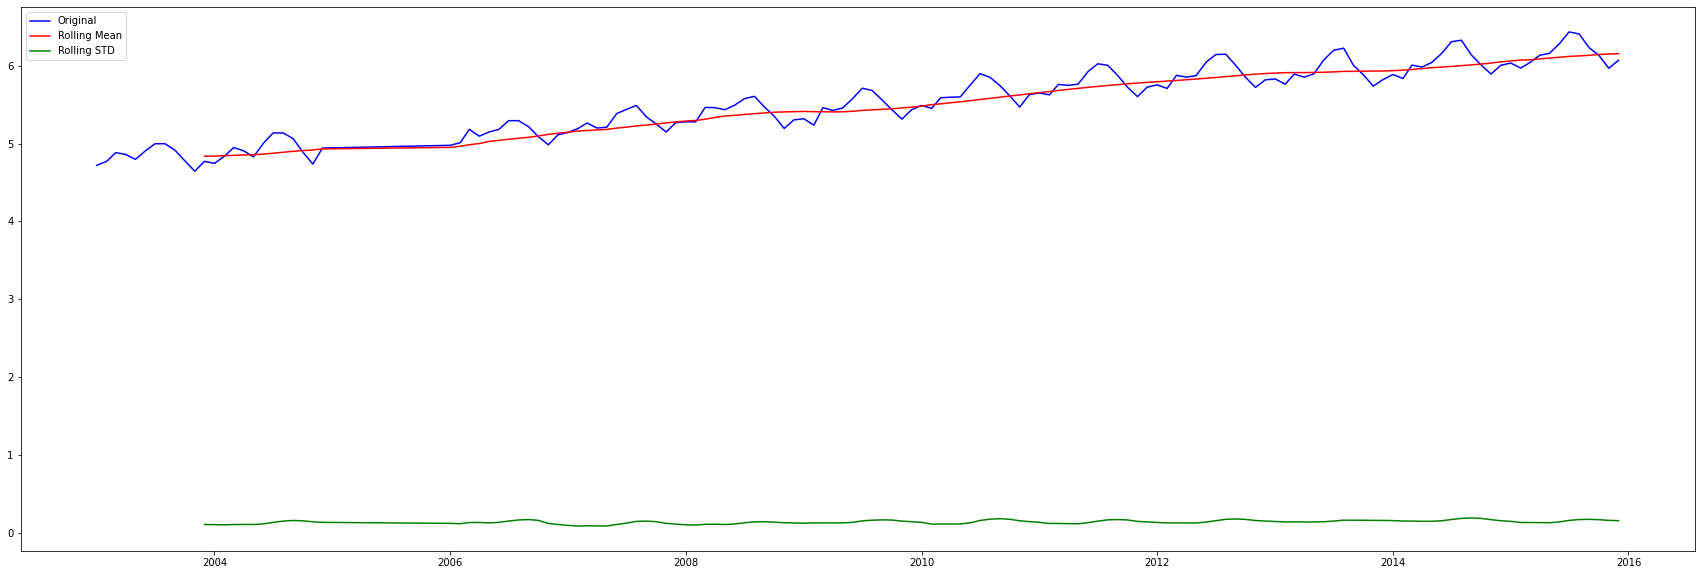

Results of Dickey-Fuller Test:
ADF Statistic      :  -1.7170170891069714
p-value            :  0.4223667747703857
#Lags Used         :  13
#Observations Used :  130
Critical Value 1%  : -3.4816817173418295
Critical Value 5%  : -2.8840418343195267
Critical Value 10%  : -2.578770059171598


In [8]:
#testing stationarity of log transformed time series
adf['Log']=test_stationarity(df_log)

In [9]:
#Trying to box cox transform the series to make it stationary
df_box=df.copy()
df_box['#Passengers'],lamda=boxcox(df['#Passengers'].values) 
df_box.head()

,#Passengers
Month,
2003-01-01,6.827490
2003-02-01,6.932822
2003-03-01,7.161892
2003-04-01,7.114611
2003-05-01,6.983787


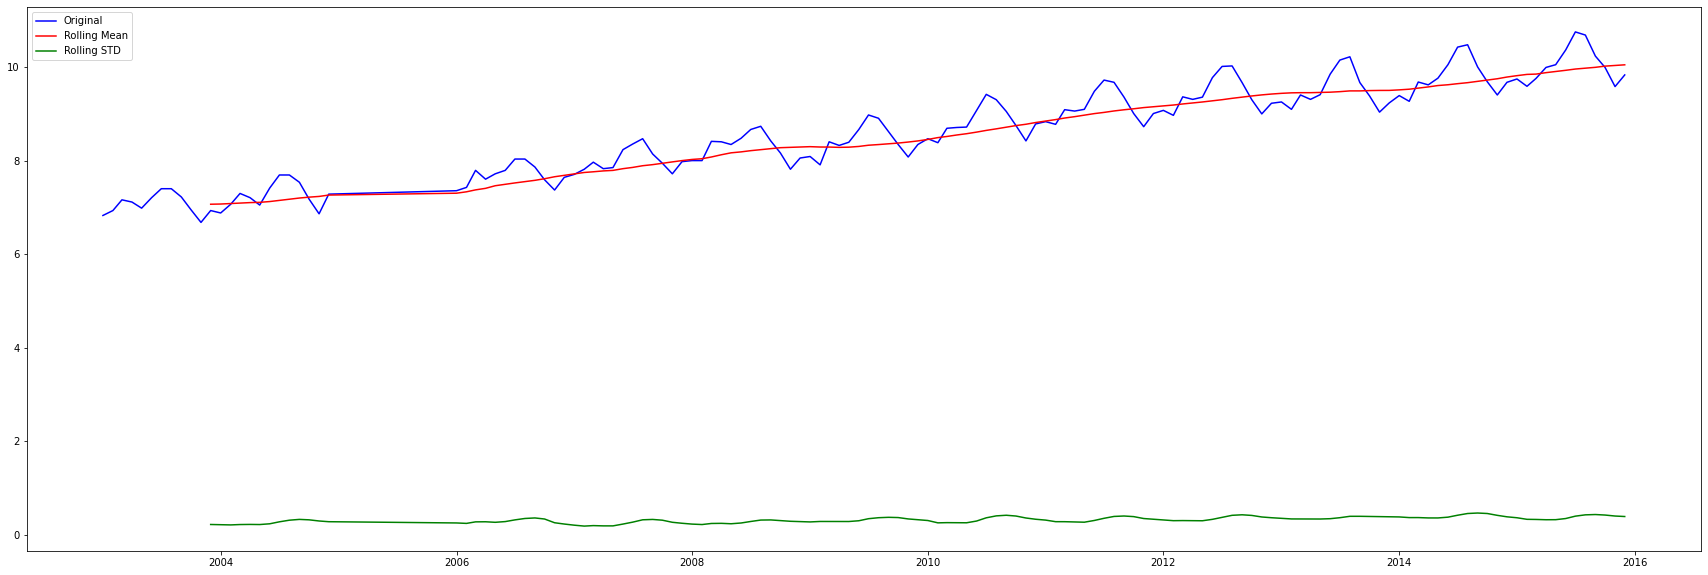

Results of Dickey-Fuller Test:
ADF Statistic      :  -1.3260708968567636
p-value            :  0.6171620657003641
#Lags Used         :  13
#Observations Used :  130
Critical Value 1%  : -3.4816817173418295
Critical Value 5%  : -2.8840418343195267
Critical Value 10%  : -2.578770059171598


In [10]:
#testing stationarity of boxcox transformed time series
adf['BoxCox']=test_stationarity(df_box)

p-value > 0.05 means Times series is non-stationary
and the statistic is larger than the critical values

In [11]:
#Trying to take difference of log transform the series to make it stationary (Weighted moving average - WMA)
dfrolmean = df_log.rolling(12).mean()
df_log_rolmean_diff = df_log - dfrolmean
df_log_rolmean_diff.head(15)

,#Passengers
Month,
2003-01-01,NaN
2003-02-01,NaN
2003-03-01,NaN
2003-04-01,NaN
2003-05-01,NaN
2003-06-01,NaN
2003-07-01,NaN
2003-08-01,NaN
2003-09-01,NaN


In [12]:
#NaN values replaced with back fill
df_log_rolmean_diff=df_log_rolmean_diff.fillna(method='bfill')
df_log_rolmean_diff.head()

,#Passengers
Month,
2003-01-01,-0.065494
2003-02-01,-0.065494
2003-03-01,-0.065494
2003-04-01,-0.065494
2003-05-01,-0.065494


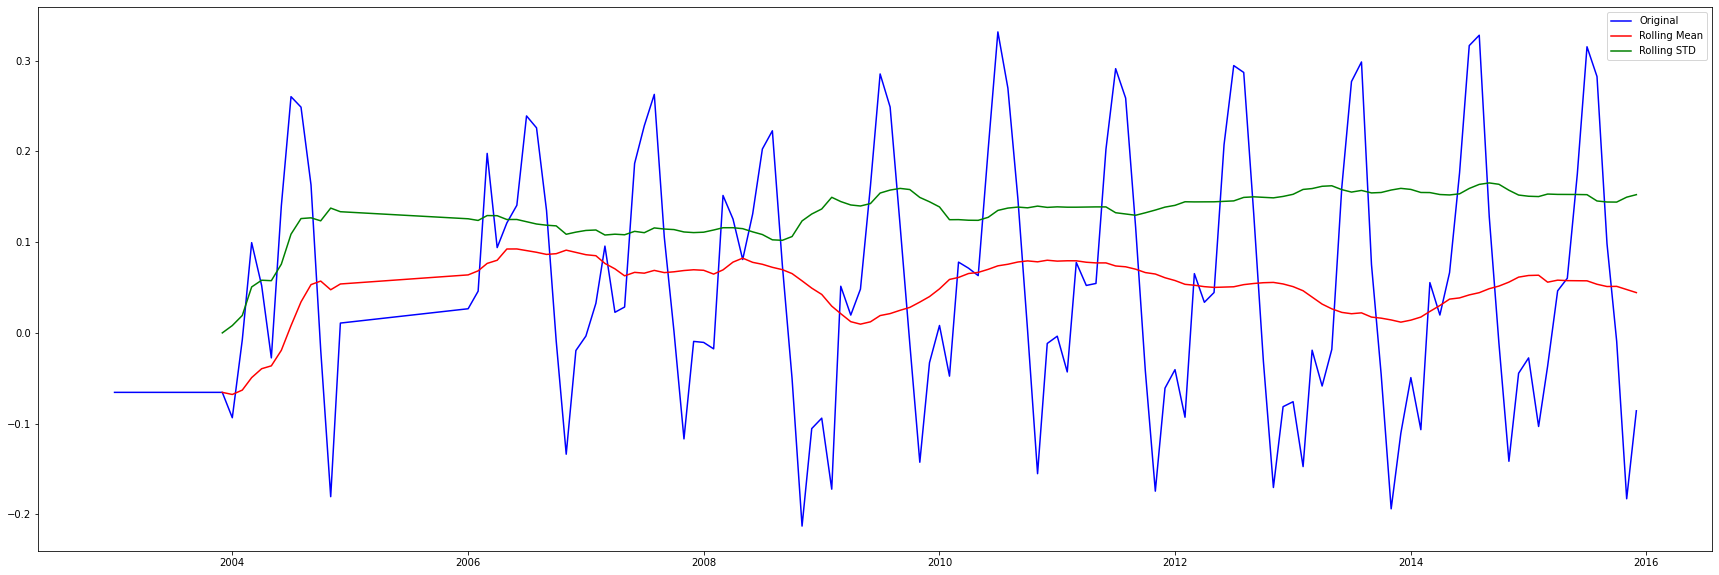

Results of Dickey-Fuller Test:
ADF Statistic      :  -4.320322836976368
p-value            :  0.00040956085138562135
#Lags Used         :  13
#Observations Used :  130
Critical Value 1%  : -3.4816817173418295
Critical Value 5%  : -2.8840418343195267
Critical Value 10%  : -2.578770059171598


In [13]:
#testing stationarity of Log WMA diff
adf['Log WMA']=test_stationarity(df_log_rolmean_diff)

This is a better transformed time series.

p-value < 0.05 means Times series is stationary and the statistic is lesser than the critical values

In [14]:
#Trying to take difference of box cox transform the series to make it stationary (Weighted moving average - WMA)
dfrolmean = df_box.rolling(12).mean()
df_box_rolmean_diff = df_box - dfrolmean
df_box_rolmean_diff.head(15)

,#Passengers
Month,
2003-01-01,NaN
2003-02-01,NaN
2003-03-01,NaN
2003-04-01,NaN
2003-05-01,NaN
2003-06-01,NaN
2003-07-01,NaN
2003-08-01,NaN
2003-09-01,NaN


In [15]:
#NaN values replaced with back fill
df_box_rolmean_diff=df_box_rolmean_diff.fillna(method='bfill')
df_box_rolmean_diff.head()

,#Passengers
Month,
2003-01-01,-0.134982
2003-02-01,-0.134982
2003-03-01,-0.134982
2003-04-01,-0.134982
2003-05-01,-0.134982


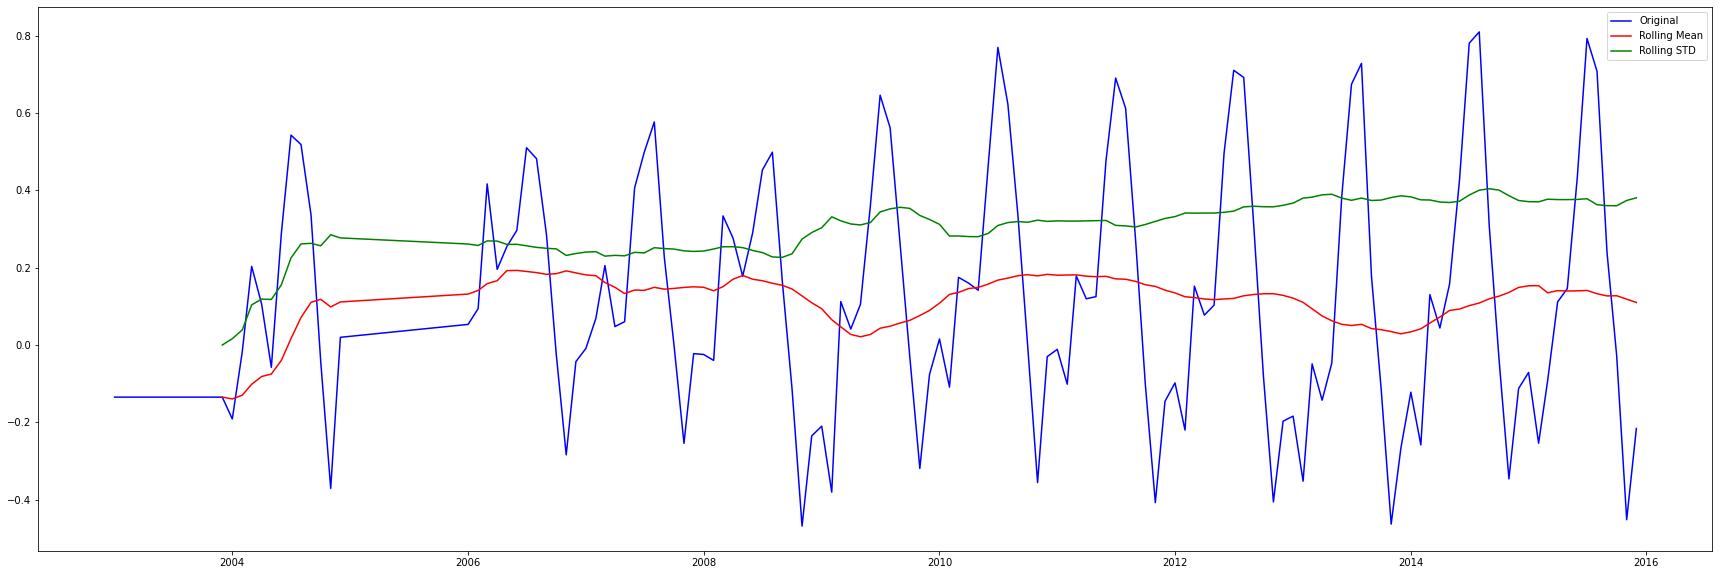

Results of Dickey-Fuller Test:
ADF Statistic      :  -4.36431827333237
p-value            :  0.0003430986787771168
#Lags Used         :  13
#Observations Used :  130
Critical Value 1%  : -3.4816817173418295
Critical Value 5%  : -2.8840418343195267
Critical Value 10%  : -2.578770059171598


In [16]:
#testing stationarity of BoxCox WMA diff
adf['Box WMA']=test_stationarity(df_box_rolmean_diff)

This looks to be better than the log transformed one.

In [17]:
#Trying another approach exponentially weighted moving average - EWMA
df_log_expwighted_mean = df_log.ewm(span=12).mean()
df_log_expwighted_mean_diff = df_log - df_log_expwighted_mean
df_log_expwighted_mean_diff.head()

,#Passengers
Month,
2003-01-01,0.000000
2003-02-01,0.023918
2003-03-01,0.082941
2003-04-01,0.041027
2003-05-01,-0.016747


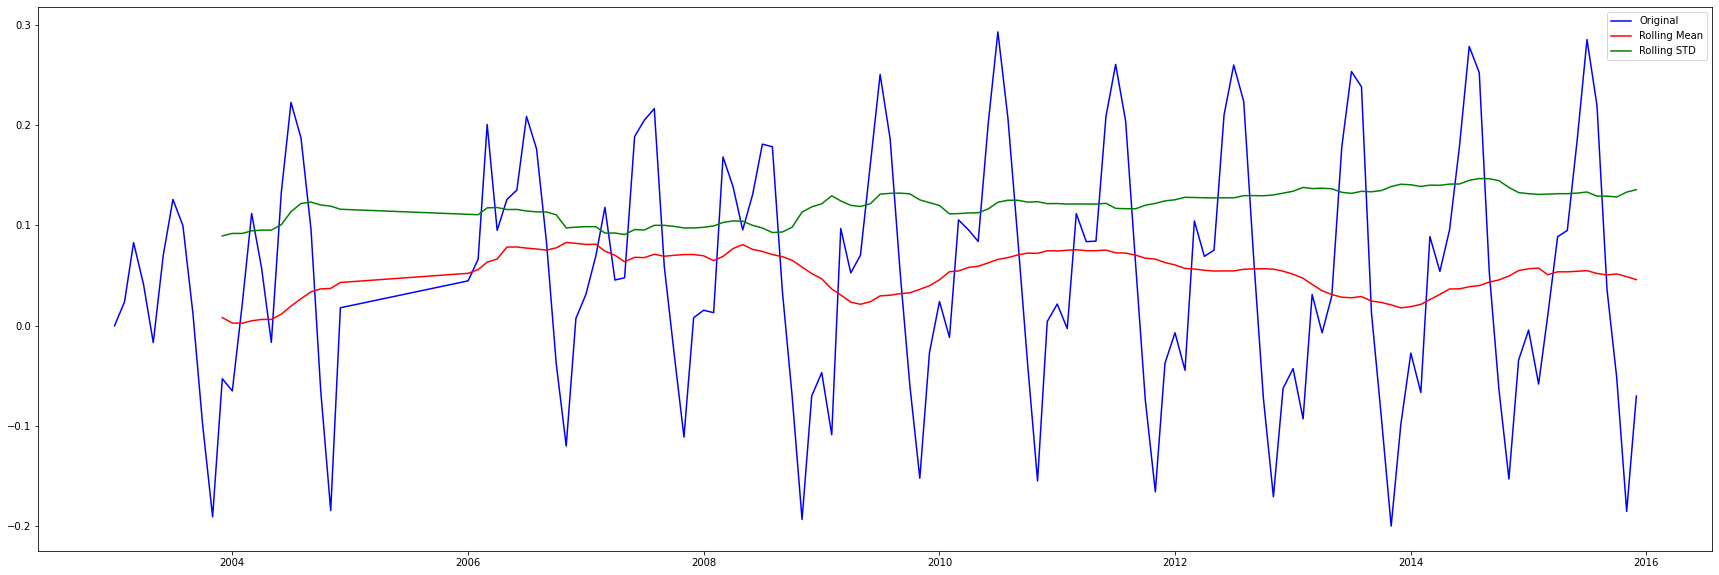

Results of Dickey-Fuller Test:
ADF Statistic      :  -3.3105424543208772
p-value            :  0.01441375329697856
#Lags Used         :  13
#Observations Used :  130
Critical Value 1%  : -3.4816817173418295
Critical Value 5%  : -2.8840418343195267
Critical Value 10%  : -2.578770059171598


In [18]:
#testing stationarity of EWMA diff
adf['Log EWMA']=test_stationarity(df_log_expwighted_mean_diff)

In [19]:
#Trying another approach exponentially weighted moving average - EWMA on boxcox
df_box_expwighted_mean = df_box.ewm(span=12).mean()
df_box_expwighted_mean_diff = df_box - df_box_expwighted_mean
df_box_expwighted_mean_diff.head()

,#Passengers
Month,
2003-01-01,0.000000
2003-02-01,0.048277
2003-03-01,0.169098
2003-04-01,0.083364
2003-05-01,-0.034565


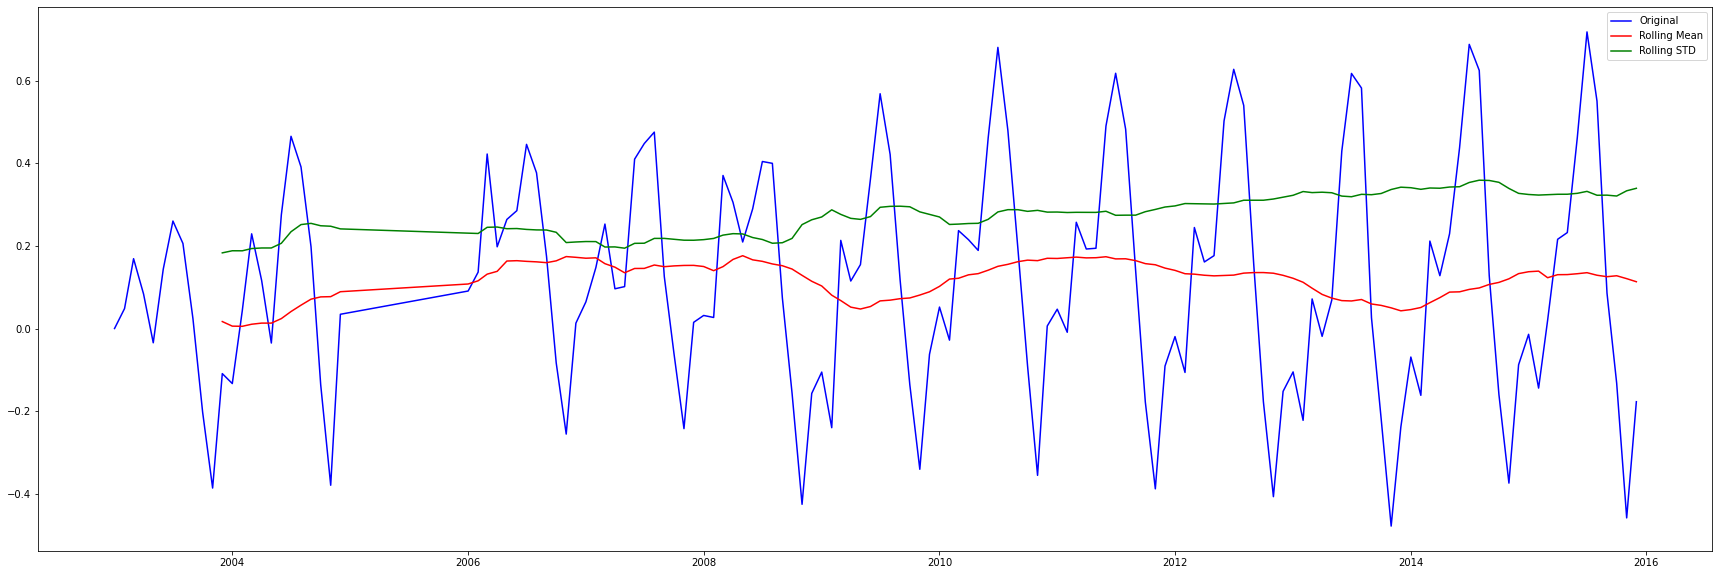

Results of Dickey-Fuller Test:
ADF Statistic      :  -3.4395885181987613
p-value            :  0.009681096354319544
#Lags Used         :  13
#Observations Used :  130
Critical Value 1%  : -3.4816817173418295
Critical Value 5%  : -2.8840418343195267
Critical Value 10%  : -2.578770059171598


In [20]:
#testing stationarity of EWMA diff
adf['Box EWMA']=test_stationarity(df_box_expwighted_mean_diff)

In [21]:
adf

,Original,Log,BoxCox,Log WMA,Box WMA,Log EWMA,Box EWMA
ADF Statistic,0.815369,-1.717017,-1.326071,-4.320323,-4.364318,-3.310542,-3.439589
p-value,0.991880,0.422367,0.617162,0.000410,0.000343,0.014414,0.009681
#Lags Used,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
#Observations Used,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
Critical Value 1%,-3.481682,-3.481682,-3.481682,-3.481682,-3.481682,-3.481682,-3.481682
Critical Value 5%,-2.884042,-2.884042,-2.884042,-2.884042,-2.884042,-2.884042,-2.884042
Critical Value 10%,-2.578770,-2.578770,-2.578770,-2.578770,-2.578770,-2.578770,-2.578770


Looking at this we can see that BOX WMA gave the best p-value and the lowest ADF statistic.
However, considering the ability to go back to the original values after prediction, we may choose either Log or BoxCox transformation.

# step 4 : Check trend and seasonality

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

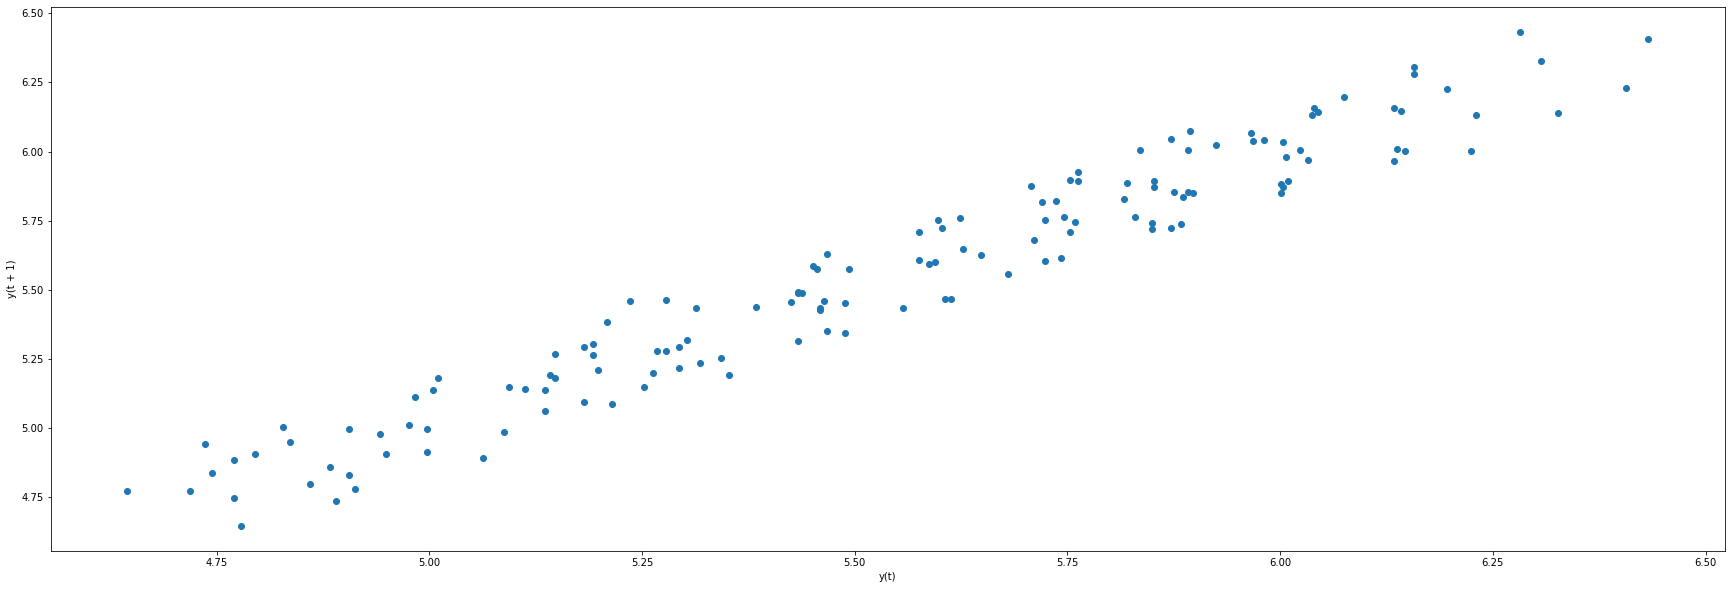

In [22]:
plt.figure(figsize=(30,10))
#Plotting to see lag for log transformed distribution
pd.plotting.lag_plot(df_log)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

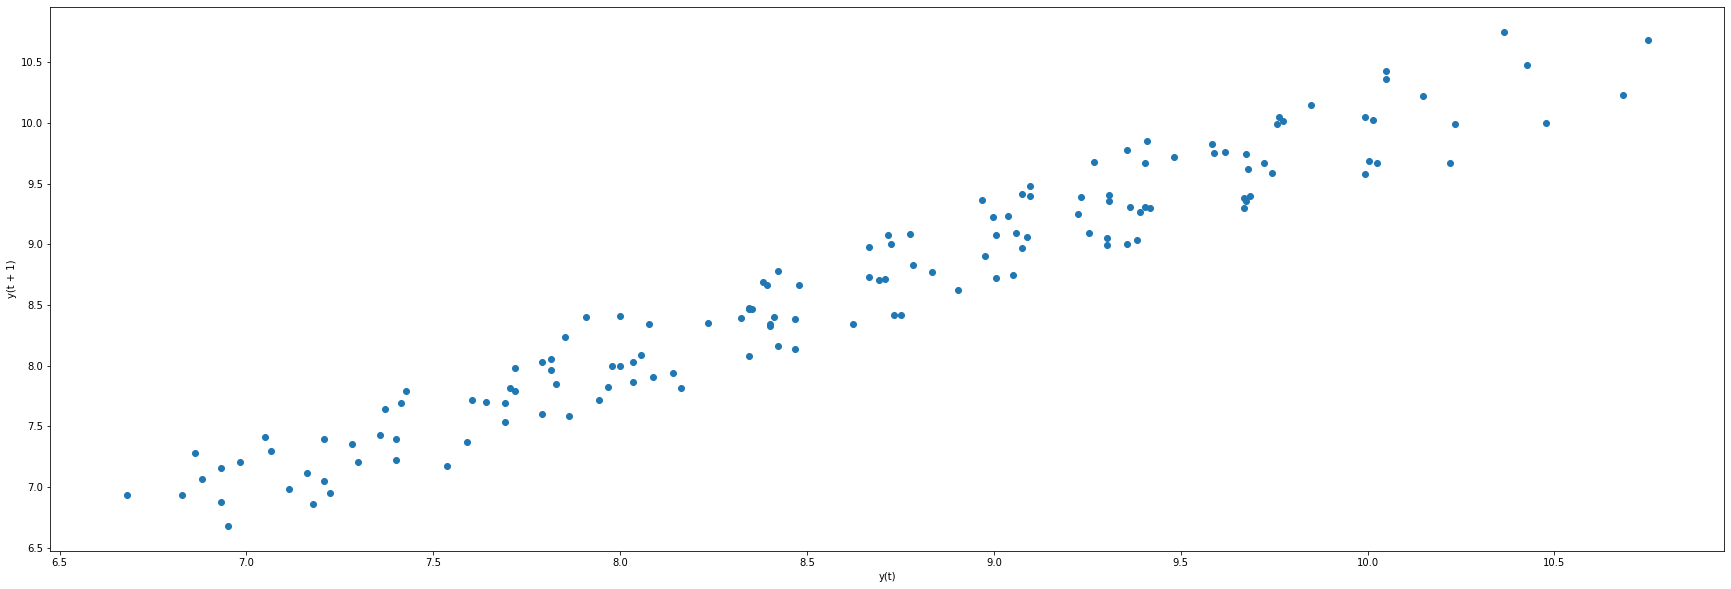

In [23]:
plt.figure(figsize=(30,10))
#Plotting to see lag for box cox transformed distribution
pd.plotting.lag_plot(df_box)

Scattered points show less correlation

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

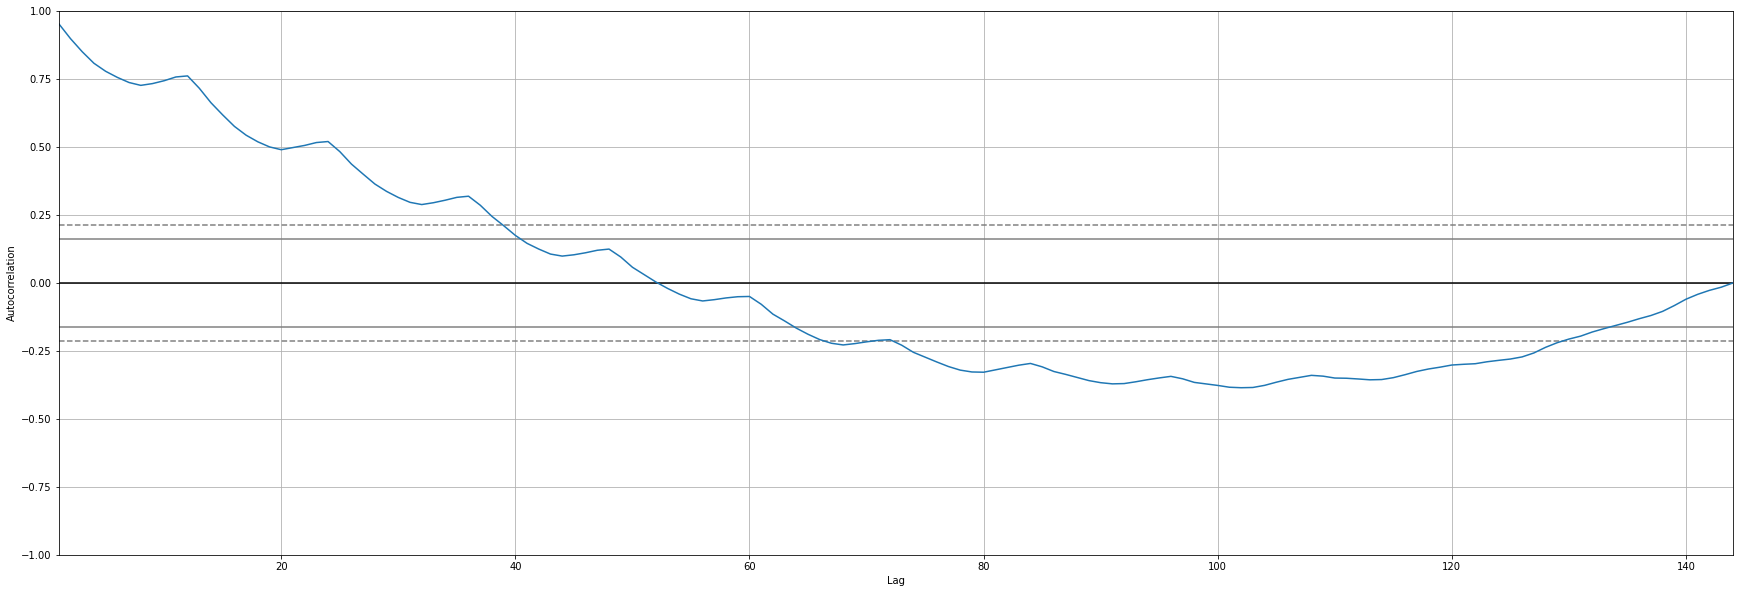

In [24]:
plt.figure(figsize=(30,10))
#Plotting auto correlation for log transform
pd.plotting.autocorrelation_plot(df_log)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

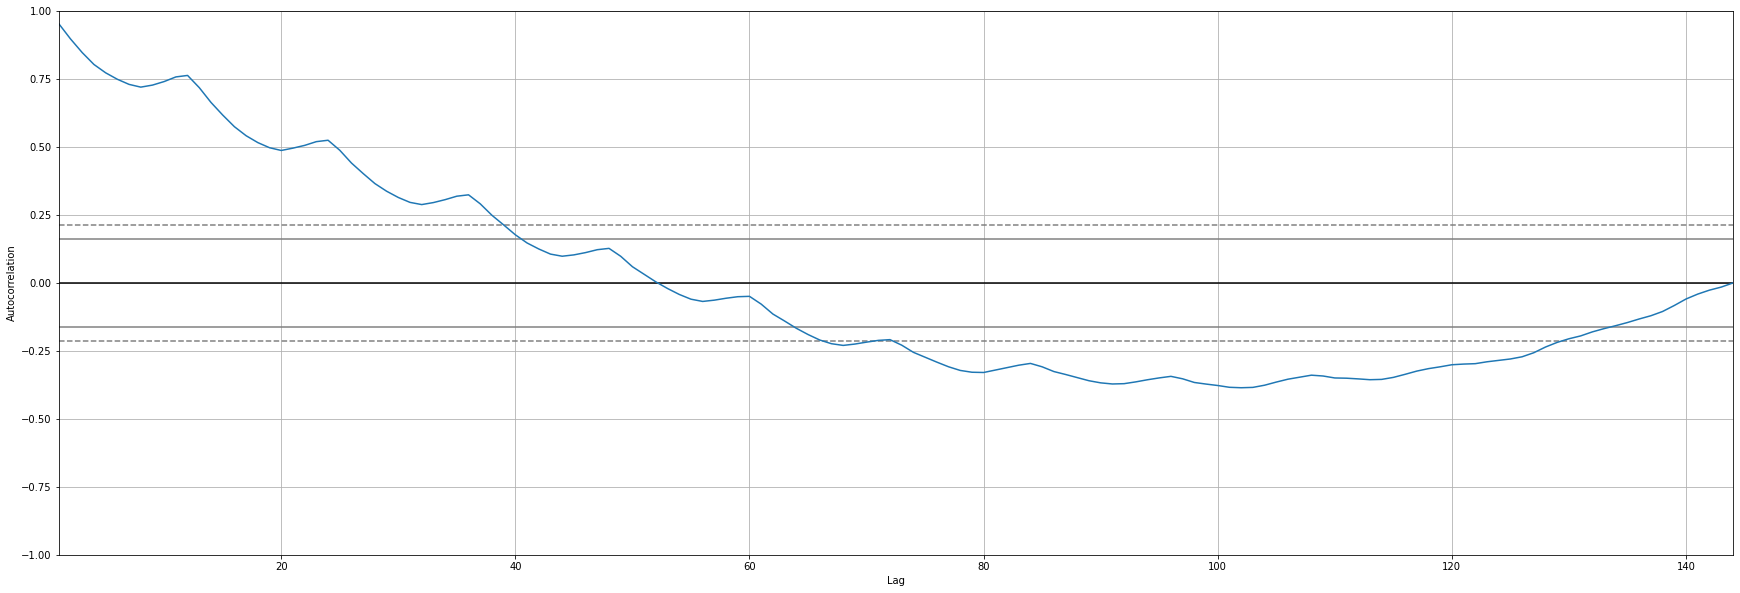

In [25]:
plt.figure(figsize=(30,10))
#Plotting auto correlation for box cox transform
pd.plotting.autocorrelation_plot(df_box)

The resulting chart contains a few lines on it separate from the autocorrelation function. The dark horizontal line at zero just denotes the zero line, the lighter full horizontal lines is the 95% confidence level and the dashed horizontal lines are 99% confidence levels, which means that correlations are more significant if they occur at those levels.

From the plot above, we can see there’s some significant correlation between t=1 and t=12 (roughly) with significant decline in correlation after that timeframe.  Since we are looking at monthly passenger data, this seems to make sense with correlations falling off at the start of the new fiscal year.

# Step 5 : Eliminating Trend and Seasonality

In [26]:
#checking the pearson correlation of the data with lagged values 
df_log['#Passengers'].corr(df_log['#Passengers'].shift(12))

0.9892251831307396

In [27]:
#checking the pearson correlation of the data with lagged values 
df_box['#Passengers'].corr(df_box['#Passengers'].shift(12))

0.989598395627461

In [28]:
#Trying the Differencing technique on Log
df_log_diff = df_log - df_log.shift()
df_log_diff = df_log_diff.fillna(0)
df_log_diff.head()

,#Passengers
Month,
2003-01-01,0.000000
2003-02-01,0.052186
2003-03-01,0.112117
2003-04-01,-0.022990
2003-05-01,-0.064022


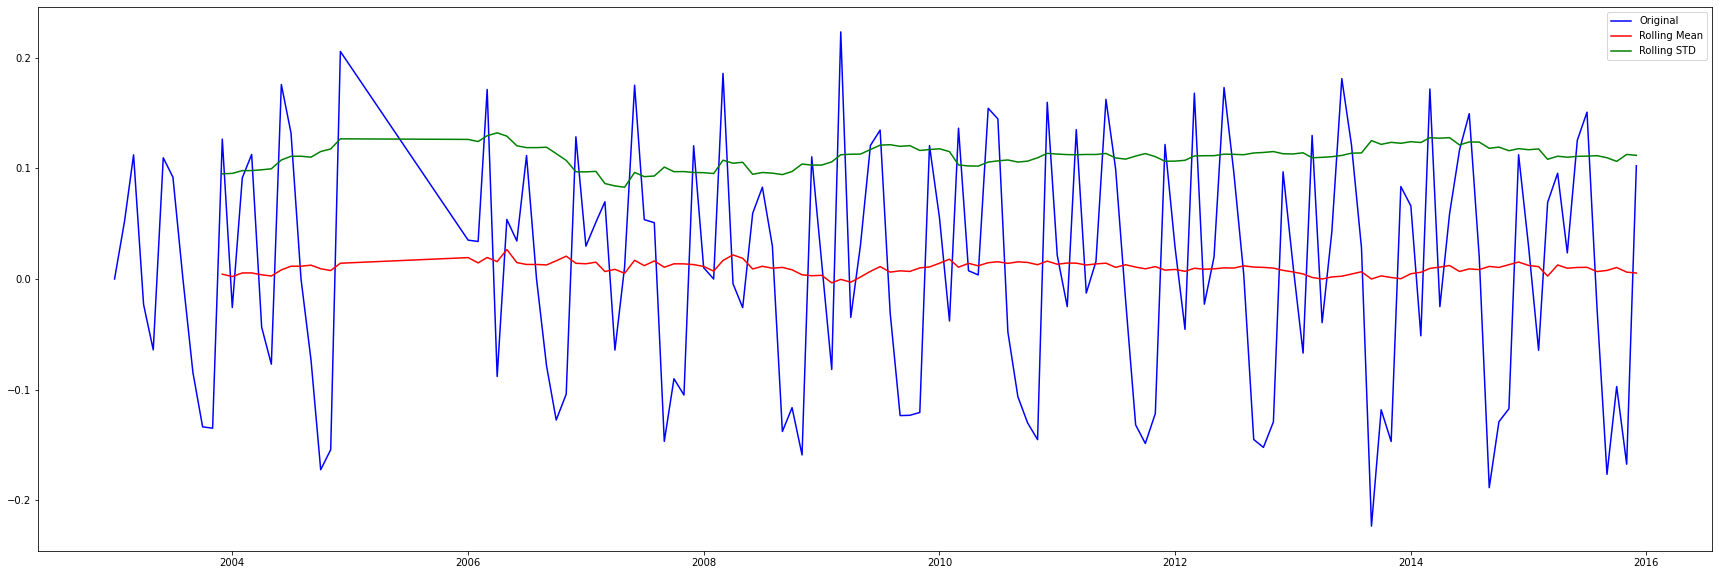

Results of Dickey-Fuller Test:
ADF Statistic      :  -2.6742902399898507
p-value            :  0.0785938171956453
#Lags Used         :  14
#Observations Used :  129
Critical Value 1%  : -3.482087964046026
Critical Value 5%  : -2.8842185101614626
Critical Value 10%  : -2.578864381347275


In [29]:
#testing stationarity of log diff
adf['Log Diff']=test_stationarity(df_log_diff)

In [30]:
#Trying the Differencing technique on box
df_box_diff = df_box - df_box.shift() #1st order differencing
df_box_diff = df_box_diff.fillna(0)
df_box_diff.head()

,#Passengers
Month,
2003-01-01,0.000000
2003-02-01,0.105332
2003-03-01,0.229069
2003-04-01,-0.047281
2003-05-01,-0.130824


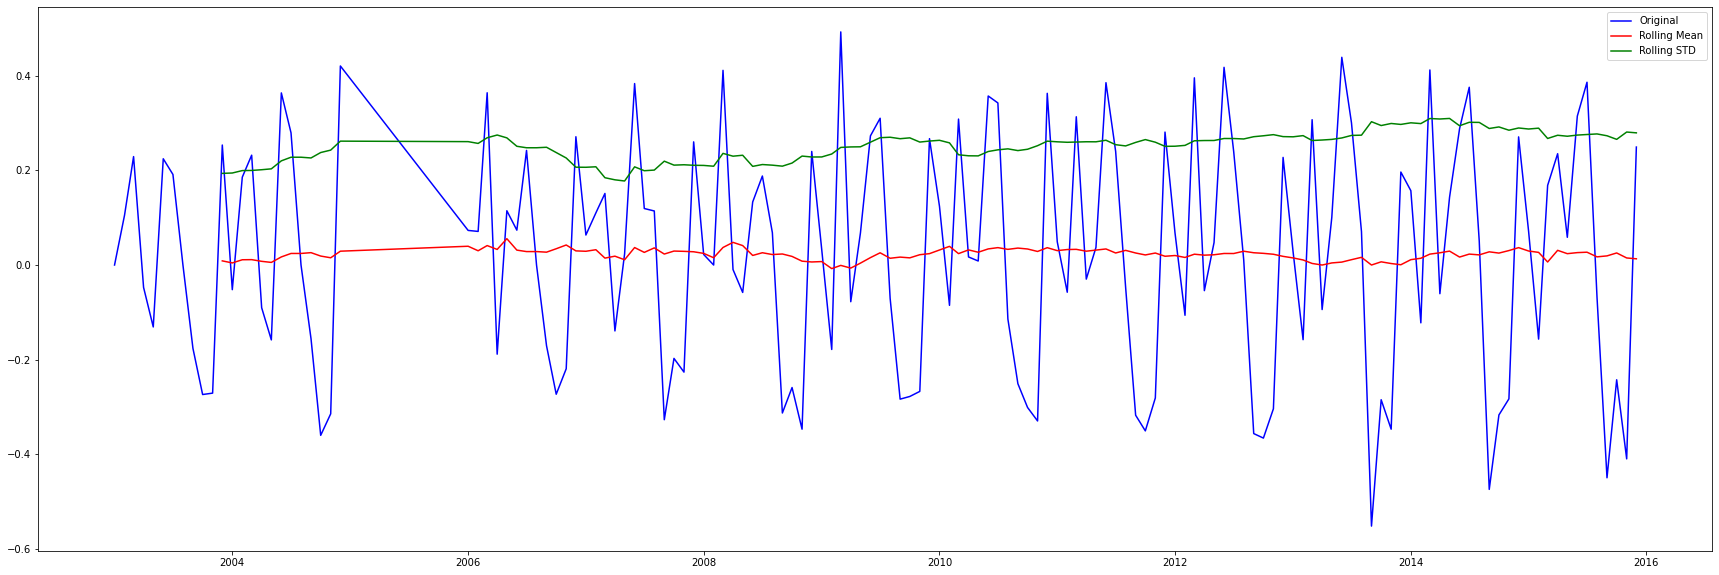

Results of Dickey-Fuller Test:
ADF Statistic      :  -2.820829016578203
p-value            :  0.055359536666326016
#Lags Used         :  14
#Observations Used :  129
Critical Value 1%  : -3.482087964046026
Critical Value 5%  : -2.8842185101614626
Critical Value 10%  : -2.578864381347275


In [31]:
#testing stationarity of Box diff
adf['Box Diff']=test_stationarity(df_box_diff)

We can see that the mean and std variations have small variations with time. Also, the Dickey-Fuller test statistic is less than the 10% critical value, thus the TS is stationary with 90% confidence. 
And the box transformed difference performs better than Log transformed difference. So, lets choose Box Cox differnce for furhter analysis.

Now lets try the decomposition option

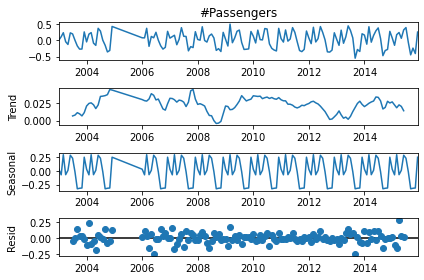

In [32]:
# Trying to do automatic decomposition as additive model (Multiplicative model is not good for 0 or -ve values)
Aresult = seasonal_decompose(df_box_diff['#Passengers'], model='additive',period=12)
Aresult.plot()
plt.show()

In [33]:
Aresult.resid.head(10)

Month
2003-01-01         NaN
2003-02-01         NaN
2003-03-01         NaN
2003-04-01         NaN
2003-05-01         NaN
2003-06-01         NaN
2003-07-01   -0.049157
2003-08-01    0.007210
2003-09-01    0.140730
2003-10-01    0.035127
Name: resid, dtype: float64

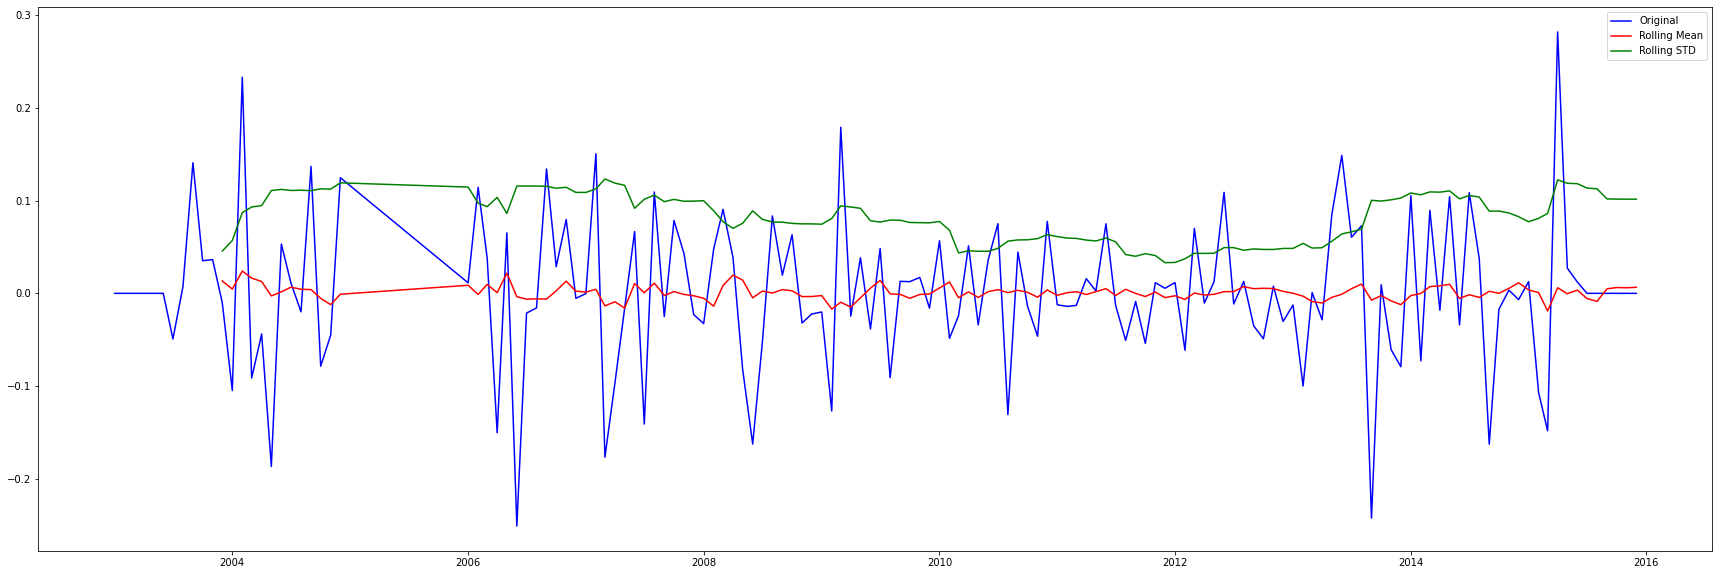

Results of Dickey-Fuller Test:
ADF Statistic      :  -7.243930602320602
p-value            :  1.853331674787868e-10
#Lags Used         :  13
#Observations Used :  130
Critical Value 1%  : -3.4816817173418295
Critical Value 5%  : -2.8840418343195267
Critical Value 10%  : -2.578770059171598


In [34]:
#testing stationarity of residuals
adf['Box Diff Decomp']=test_stationarity(Aresult.resid.fillna(0))

In [35]:
adf

,Original,Log,BoxCox,Log WMA,Box WMA,Log EWMA,Box EWMA,Log Diff,Box Diff,Box Diff Decomp
ADF Statistic,0.815369,-1.717017,-1.326071,-4.320323,-4.364318,-3.310542,-3.439589,-2.674290,-2.820829,-7.243931e+00
p-value,0.991880,0.422367,0.617162,0.000410,0.000343,0.014414,0.009681,0.078594,0.055360,1.853332e-10
#Lags Used,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,14.000000,14.000000,1.300000e+01
#Observations Used,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,129.000000,129.000000,1.300000e+02
Critical Value 1%,-3.481682,-3.481682,-3.481682,-3.481682,-3.481682,-3.481682,-3.481682,-3.482088,-3.482088,-3.481682e+00
Critical Value 5%,-2.884042,-2.884042,-2.884042,-2.884042,-2.884042,-2.884042,-2.884042,-2.884219,-2.884219,-2.884042e+00
Critical Value 10%,-2.578770,-2.578770,-2.578770,-2.578770,-2.578770,-2.578770,-2.578770,-2.578864,-2.578864,-2.578770e+00


Decomposition gives the best ADF & p-value, however, I think we can go with box cox transformation and differncing as that gives a satisfactory output distibution and it is easy to convert back to original distribution after prediction

# Step 7 : Prepare a method to take back the distribution to original

In [36]:
# this is our current transformed distribution. After prediction we will be getting the predicted values in this scale.
df_box_diff.head()

,#Passengers
Month,
2003-01-01,0.000000
2003-02-01,0.105332
2003-03-01,0.229069
2003-04-01,-0.047281
2003-05-01,-0.130824


In [37]:
#Step1 is to remove the differencing and get the box cox transformed time series.
# Take cumulative sum 
bdf_box_cumsum= df_box_diff.cumsum()
# Adding the starting value of the original time series to make the shifting back correct after cumulative sum.
bdf_box = df_box.iloc[0] + bdf_box_cumsum
#Note : this has a very minor dependency on the original time series. But it is just the frst value.

In [38]:
#Step2 is to take inverse box cox as we originally did box cox transform
bdf=df.copy()
bdf['Reverted']=inv_boxcox(bdf_box,lamda)
bdf

,#Passengers,Reverted
Month,,
2003-01-01,112,112.0
2003-02-01,118,118.0
2003-03-01,132,132.0
2003-04-01,129,129.0
2003-05-01,121,121.0
...,...,...
2015-08-01,606,606.0
2015-09-01,508,508.0
2015-10-01,461,461.0


We have got the exact same time series as original after inversing. The same can be done wiht log transform as well if we had selected it.

# Step 8 : Establish a baseline for performance

In [39]:
X=df_org.values
#We can split the data to train & split on a pecentage basis as below.
#Splitting for train (50%) & Test (50%)
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=229.000, Expected=242
>Predicted=242.000, Expected=233
>Predicted=233.000, Expected=267
>Predicted=267.000, Expected=269
>Predicted=269.000, Expected=270
>Predicted=270.000, Expected=315
>Predicted=315.000, Expected=364
>Predicted=364.000, Expected=347
>Predicted=347.000, Expected=312
>Predicted=312.000, Expected=274
>Predicted=274.000, Expected=237
>Predicted=237.000, Expected=278
>Predicted=278.000, Expected=284
>Predicted=284.000, Expected=277
>Predicted=277.000, Expected=317
>Predicted=317.000, Expected=313
>Predicted=313.000, Expected=318
>Predicted=318.000, Expected=374
>Predicted=374.000, Expected=413
>Predicted=413.000, Expected=405
>Predicted=405.000, Expected=355
>Predicted=355.000, Expected=306
>Predicted=306.000, Expected=271
>Predicted=271.000, Expected=306
>Predicted=306.000, Expected=315
>Predicted=315.000, Expected=301
>Predicted=301.000, Expected=356
>Predicted=356.000, Expected=348
>Predicted=348.000, Expected=355
>Predicted=355.000, Expected=422
>Predicted

In this case, we can see that the persistence model achieved an RMSE of 43.529. This means that on average, the model was wrong by about 43 passengers for each prediction made. This RMSE we can take as a baseline.